© 2025 Zitao Yang, Rebecca J. Rousseau, Sara D. Mahdavi, Hernan G. Garcia, and Rob Phillips, *The Dynamics of Inducible Genetic Circuits*. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).
___

# Comparison of Hill function and Thermodynamic models

This notebook generates the plots shown in Figure 12 as well as Appendix Figures 30-31 of the paper. The figures compare Hill function and thermodynamic formulations for the bifurcation diagram of auto-activation.

## General helper functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Figure formatting

SMALL_SIZE = 15
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams.update({
    "text.usetex": True,
    'mathtext.fontset': 'stix',
    "font.family": 'STIXGeneral',
    "axes.labelpad": 8.0
})

# Helper function

def pAct(C, Ka=1.4*10**(-4), Ki=5.3*10**(-7), delE=4.5):
    """ Probability of repressor/activator being active
    
    Parameters:
        - C: effector concentration
        - Ka: dissociation constant in active state
        - Ki: dissociation constant in inactive state
        - delE: energy difference between inactive and active state
    """

    p = (1 + C/Ka)**2 / ((1 + C/Ka)**2 + np.exp(-delE)*(1 + C/Ki)**2)
    return p

## Fig. 12: Comparison between Hill function and thermodynamic models for auto-activation

This figure plots bifurcation diagrams for the Hill formulation and for thermodynamic formulations having different rate and cooperativity parameters. Comparison demonstrates first that (A) the two models contradict each other in predicting the region of effector concentrations exhibiting bistability, and (B) the Hill function does not capture the flexibility of EC50s possible for different thermodynamic formulations.

## Helper functions

In [20]:
def evolveAutoActivation(A, p, r0, r1, r2, w, delt):
    """Evolve the concentration of activator through a given time step

    Arguments:
        - A: dimensionless concentration of activator
        - p: p_act, probability of A being active
        - r0: r_0, basal rate of activator mRNA expression, i.e., expression rate
          for unbound regulatory state (dimensionless)
        - r1: r_1, rate of activator mRNA expression in regulatory state with
          one bound activator (dimensionless)
        - r2: r_2, rate of activator mRNA expression in regulatory state with
          two bound activators (dimensionless)
        - w: cooperativity
        - delt: time step
    """    
    dAdt = - A + r0/(1 + 2*(p*A) + w*(p*A)**2) + r1*(2*p*A)/(1 + 2*(p*A) + w*(p*A)**2) + \
            r2*(w*(p*A)**2)/(1 + 2*(p*A) + w*(p*A)**2)
    
    Anew = A + dAdt * delt

    return Anew


def steadyStateAutoActivation(p, r0, r1, r2, w):
    """Find the auto-activation steady states given parameters

    Arguments:
        - p: p_act, probability of A being active
        - r0: r_0, basal rate of activator mRNA expression, i.e., expression rate
          for unbound regulatory state (dimensionless)
        - r1: r_1, rate of activator mRNA expression in regulatory state with
          one bound activator (dimensionless)
        - r2: r_2, rate of activator mRNA expression in regulatory state with
          two bound activators (dimensionless)
        - w: cooperativity
    """
    coeff = [w*p**2, 2*p-r2*w*p**2, 1-2*r1*p, -r0]

    return np.roots(coeff)

def steadyStateKd(Kd, r0, r1, r2, w):
    """ Steady state of simple regulation in Kd language

    Arguments:
        - Kd: dissociation constant (effective)
        - r0: production rate when no TF is bound
        - r1: production rate when one TF is bound
        - r2: production rate when two TFs is bound
        - w: cooperativity
    """
    coeff = [-w/Kd**2, -2/Kd + w*r2/Kd**2, 2*r1/Kd - 1, r0]
    roots = np.roots(coeff)
    good_roots = np.real(roots[np.isreal(roots)])
    good_roots = np.sort(good_roots[good_roots >= 0])

    return good_roots

def steadyStateAutoActivationHill(p, r0, r2, n):
    """ Steady states of auto-activation in Hill formulation

    Arguments:
        - p: p_act, probability of A being active
        - r0: production rate when no TF is bound (dimensionless)
        - r2: production rate when two TFs is bound (dimensionless)
        - n: Hill coefficient
    """
    coeff = np.zeros(n+2)
    coeff[0] = -p**n
    coeff[1] = r2*p**n
    coeff[-2] = -1
    coeff[-1] = r0

    return np.roots(coeff)

def thermo_weights(x, w):
    """ List the thermodynamic weights for the unbound state, for one TF bound,
    and for two TFs bound

    Arguments:
        - x: dimensionless concentration of activator
        - w: cooperativity
    """
    weights = [1/(1 + 2*x + w*x**2), 2*x/(1 + 2*x + w*x**2), w*x**2/(1 + 2*x + w*x**2)]

    return weights

def hill_weights(x, n):
    """ List the weights from the Hill function model for the unbound state
    and for the TF-bound state

    Arguments:
        - x: dimensionless concentration of activator
        - n: Hill exponent
    """
    weights = [1/(1 + x**n), x**n/(1 + x**n)]

    return weights

### Plotting functions

In [27]:
def plot_bifurcation_curve_thermo(ax, r0, r1, r2, w, cmin=-7, cmax=-4, length=200, label=r"thermodynamic", color="C0"):
    """ Plot bifurcation diagram for the thermodynamic formulation

    Arguments:
        - ax: dimensionless concentration of activator
        - r0: production rate when no TF is bound (dimensionless)
        - r1: production rate when one TF is bound (dimensionless)
        - r2: production rate when two TFs is bound (dimensionless)
        - w: cooperativity
        - cmin: 10^(cmin), minimum effector concentration sampled (M)
        - cmax: 10^(cmax), maximum effector concentration sampled (M)
        - length: number of effector concentrations sampled in specified range
    """
    # Range of effector concentrations to be sampled
    Cs = np.logspace(cmin, cmax, length)
    # Map into pAct
    p_acts = pAct(Cs)

    # Find the steady states corresponding to each c
    Rs = []
    for i in range(len(p_acts)):
        Rs.append(steadyStateAutoActivation(p=p_acts[i], r0=r0, r1=r1, r2=r2, w=w))

    # Select real and positive roots
    Rs = np.concatenate(Rs)
    real_Rs = np.real(Rs[np.isreal(Rs)])
    real_Cs = np.repeat(Cs, 3)[np.isreal(Rs)]

    positive_Rs = real_Rs[real_Rs >= 0]
    positive_Cs = real_Cs[real_Rs >= 0]

    # Plot the bifurcation curve
    ax.scatter(positive_Cs, positive_Rs, s=10, label=label, c=color)

def plot_bifurcation_curve_Hill(ax, r0, r2, n, cmin=-7, cmax=-4, length=200, label=r"Hill function", color="C1"):
    """ Plot bifurcation diagram for the Hill function formulation

    Arguments:
        - ax: dimensionless concentration of activator
        - r0: production rate when no TF is bound (dimensionless)
        - r2: production rate when TFs bound (dimensionless)
        - n: Hill coefficient
        - cmin: 10^(cmin), minimum effector concentration sampled (M)
        - cmax: 10^(cmax), maximum effector concentration sampled (M)
        - length: number of effector concentrations sampled in specified range
    """
    # Range of effector concentrations to be sampled
    Cs = np.logspace(cmin, cmax, length)
    # map into pAct
    p_acts = pAct(Cs)

    # Find the steady states corresponding to each c
    Rs = []
    for i in range(len(p_acts)):
        Rs.append(steadyStateAutoActivationHill(p=p_acts[i], r0=r0, r2=r2, n=n))

    # Select real and positive roots
    Rs = np.concatenate(Rs)
    real_Rs = np.real(Rs[np.isreal(Rs)])
    real_Cs = np.repeat(Cs, n+1)[np.isreal(Rs)]

    positive_Rs = real_Rs[real_Rs >= 0]
    positive_Cs = real_Cs[real_Rs >= 0]

    # Plot the bifurcation curve
    ax.scatter(positive_Cs, positive_Rs, s=10, label=label, c=color)

### (A): Contradiction of bistability prediction

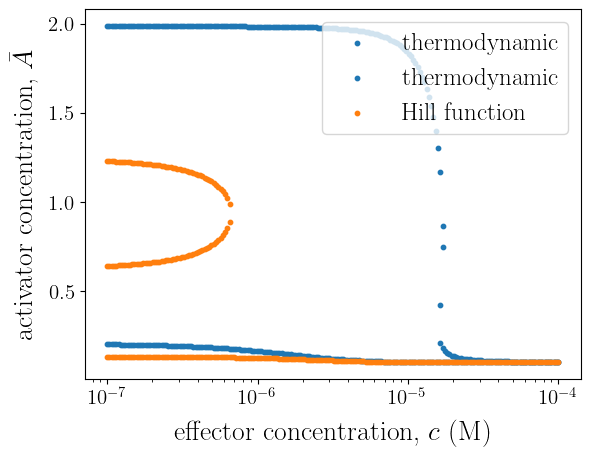

In [29]:
fig, ax = plt.subplots()

r0, r2 = 0.1, 2

# Plot first thermo bifurcation curve
r1, w = 0.1, 2
plot_bifurcation_curve_thermo(ax, r0, r1, r2, w)

# Plot second thermo bifurcation curve
r1, w = 1, 100
plot_bifurcation_curve_thermo(ax, r0, r1, r2, w)

# Plot Hill bifurcation curve
plot_bifurcation_curve_Hill(ax, r0, r2, 2)

plt.xscale("log")
plt.legend(loc="upper right")
plt.xlabel(r"effector concentration, $c$ (M)")
plt.ylabel(r"activator concentration, $\bar{A}$")
plt.show()

Note that the blue thermodynamic curve at high activator concentration $\bar{A}\rightarrow 2$ for small effector concentration corresponds to $\bar{r}_{1} = 1$, $\omega = 100$, and the thermodynamic curve showing little change in activator concentration as a function of effector concentration corresponds to $\bar{r}_{1} = 0.1$, $\omega = 2$.

### (B): Flexibility of $\rm EC_{50}$

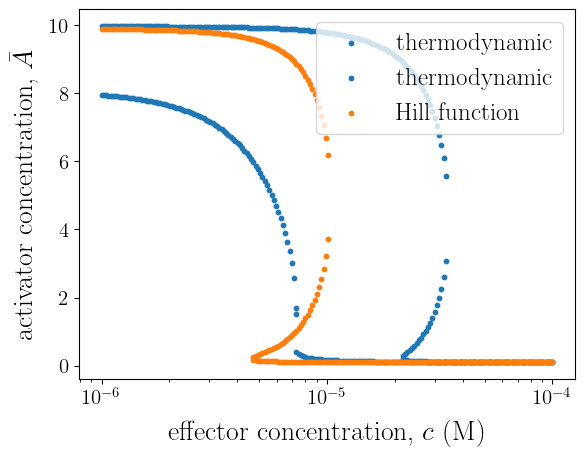

In [35]:
fig, ax = plt.subplots()

r0, r2 = 0.1, 10

# Plot first thermo bifurcation curve
r1, w = 1, 1
plot_bifurcation_curve_thermo(ax, r0, r1, r2, w, cmin=-6)

# Plot second thermo bifurcation curve
r1, w = 1, 50
plot_bifurcation_curve_thermo(ax, r0, r1, r2, w, cmin=-6)

# Plot Hill bifurcation curve
plot_bifurcation_curve_Hill(ax, r0, r2, 2, cmin=-6)

plt.xscale("log")
plt.legend(loc="upper right")
plt.xlabel(r"effector concentration, $c$ (M)")
plt.ylabel(r"activator concentration, $\bar{A}$")
plt.show()

Note that the thermodynamic curve with the lower $\rm EC_{50}$ corresponds to $\bar{r}_{1} = 1$, $\omega = 1$, and the thermodynamic curve with the higher $\rm EC_{50}$ corresponds to $\bar{r}_{1} = 1$, $\omega = 50$.

# Appendix Figures

## Fig. 30: Comparison of statistical mechanical weights for activator-bound states

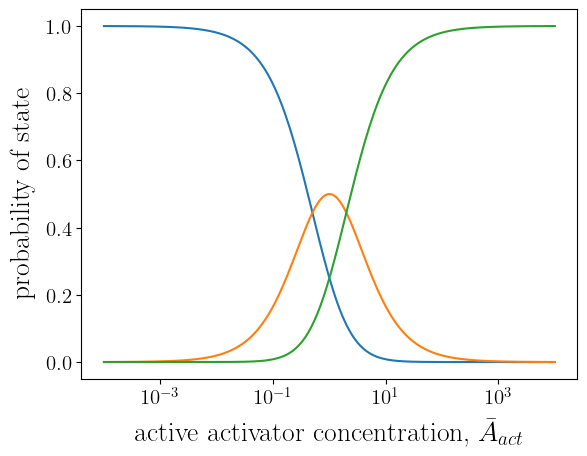

In [40]:
length = 200

xs = np.logspace(-4, 4, length)

# Thermodynamic probability of states, w=1
weight_th_wlow = thermo_weights(xs, 1)
plt.plot(xs, weight_th_wlow[0])
plt.plot(xs, weight_th_wlow[1])
plt.plot(xs, weight_th_wlow[2])
plt.xlabel(r"active activator concentration, $\bar{A}_{act}$")
plt.ylabel(r"probability of state")
plt.xscale("log")
plt.show()

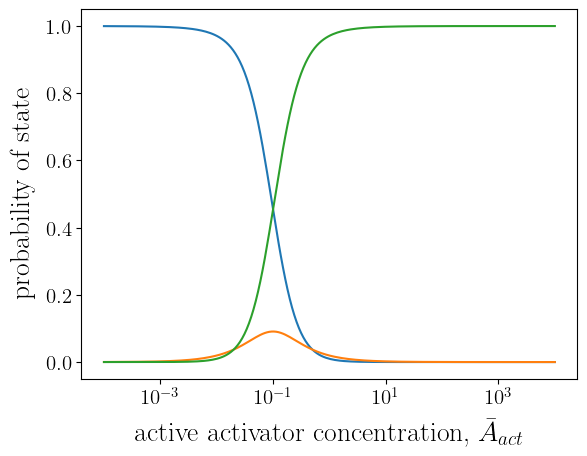

In [42]:
# Thermodynamic probability of states, w=100
weight_th_whigh = thermo_weights(xs, 100)
plt.plot(xs, weight_th_whigh[0])
plt.plot(xs, weight_th_whigh[1])
plt.plot(xs, weight_th_whigh[2])
plt.xlabel(r"active activator concentration, $\bar{A}_{act}$")
plt.ylabel(r"probability of state")
plt.xscale("log")
plt.show()

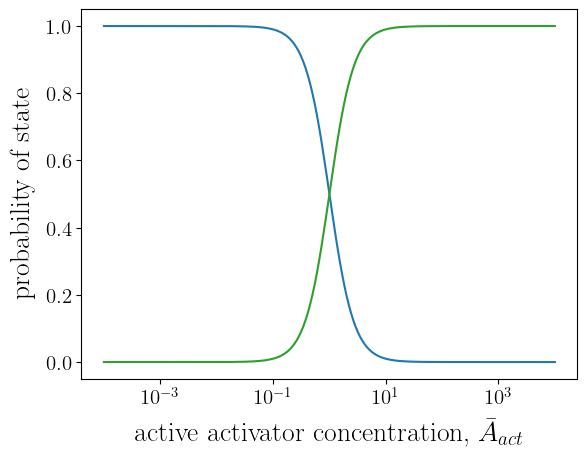

In [44]:
# Hill function probability of states, n=2
weight_hill = hill_weights(xs, 2)
plt.plot(xs, weight_hill[0])
plt.plot(xs, weight_hill[1], c="C2")
plt.xlabel(r"active activator concentration, $\bar{A}_{act}$")
plt.ylabel(r"probability of state")
plt.xscale("log")
plt.show()

Note that in the above figures the blue curve corresponds to the state with no activator bound, the orange curve corresponds to the state with one activator bound, and the green curve corresponds to the state with two activators bound.

## Fig. 31. Fixed $\rm EC_{50}$ for Hill functions with varying Hill coefficient

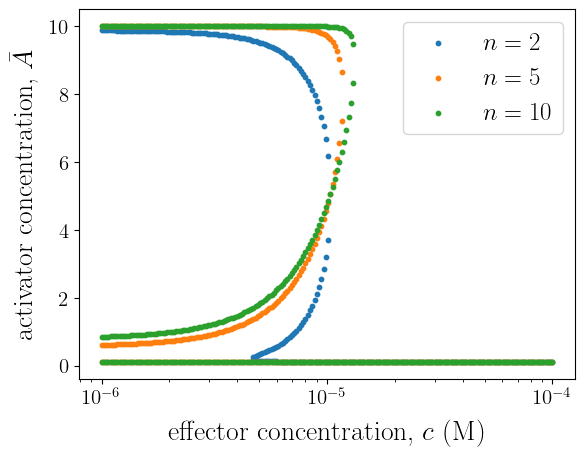

In [48]:
fig, ax = plt.subplots()

r0, r2 = 0.1, 10

# Plot Hill bifurcation curve
plot_bifurcation_curve_Hill(ax, r0, r2, 2, cmin=-6, color="C0", label=r"$n=2$")
plot_bifurcation_curve_Hill(ax, r0, r2, 5, cmin=-6, color="C1", label=r"$n=5$")
plot_bifurcation_curve_Hill(ax, r0, r2, 10, cmin=-6, color="C2", label=r"$n=10$")

plt.xscale("log")
plt.legend(loc="upper right")
plt.xlabel(r"effector concentration, $c$ (M)")
plt.ylabel(r"activator concentration, $\bar{A}$")
plt.show()